In [1]:
# the data is obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/student+performance
# in this notebook, I predict the math scores of secondary school students in two Portuguese schools
# the prediction problem is a regression problem (math score is between 0 and 20 inclusive)

In [2]:
# clear all variables, functions, etc
%reset -f

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np #foundational package for scientific computing
import matplotlib as mpl #collection of functions for scientific and publication-ready visualization
import matplotlib.pyplot as plt
from IPython import display #pretty printing of dataframes in Jupyter notebook
import seaborn as sns #data visualization

print('All libraries loaded successfully')

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# Fixing random state for reproducibility
np.random.seed(123)

All libraries loaded successfully


In [3]:
# import dataset
full = pd.read_csv('../data/math_grades/student-mat.csv', sep=';')

# drop select variables
full = full.drop(['school','address'], axis=1)

In [4]:
# check for missing values
full.isnull().sum() # no missing values

sex           0
age           0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

-0.7326723530443435


C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


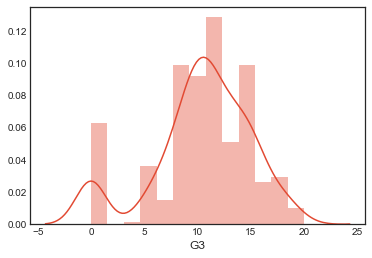

In [5]:
# check for data entry errors in the target variable (target variable should be between 0 and 20 inclusive)
sns.distplot(full['G3'], kde=True) # no data entry errors

# rename target variable
full = full.rename(index=str, columns={"G3": "score"})

# calculate skewness of the target variable
print(full['score'].skew()) # target variable is moderately left-skewed (because of the zero scores); let's leave it for now

In [6]:
# one-hot encode the categorical variables
full = pd.get_dummies(full)

# ensure all data types are now numeric
full.dtypes

age                  int64
Medu                 int64
Fedu                 int64
traveltime           int64
studytime            int64
failures             int64
famrel               int64
freetime             int64
goout                int64
Dalc                 int64
Walc                 int64
health               int64
absences             int64
G1                   int64
G2                   int64
score                int64
sex_F                uint8
sex_M                uint8
famsize_GT3          uint8
famsize_LE3          uint8
Pstatus_A            uint8
Pstatus_T            uint8
Mjob_at_home         uint8
Mjob_health          uint8
Mjob_other           uint8
Mjob_services        uint8
Mjob_teacher         uint8
Fjob_at_home         uint8
Fjob_health          uint8
Fjob_other           uint8
Fjob_services        uint8
Fjob_teacher         uint8
reason_course        uint8
reason_home          uint8
reason_other         uint8
reason_reputation    uint8
guardian_father      uint8
g

In [7]:
# view the five variables that are most negatively correlated with the target variable
print(full.corr()['score'].sort_values()[0:5])
print('-'*50)

# view the five variables that are most positively correlated with the target variable
print(full.corr()['score'].sort_values(ascending=False)[0:5])

failures       -0.360415
higher_no      -0.182465
age            -0.161579
goout          -0.132791
romantic_yes   -0.129970
Name: score, dtype: float64
--------------------------------------------------
score         1.000000
G2            0.904868
G1            0.801468
Medu          0.217147
higher_yes    0.182465
Name: score, dtype: float64


In [8]:
# split data into train and test sets
from sklearn import model_selection
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(full.drop(['score'], axis=1), full['score'], test_size=0.2)

       linreg_pred      score
count    79.000000  79.000000
mean     10.963842  11.025316
std       4.308103   4.790414
min       0.000000   0.000000
25%       8.267578   9.000000
50%      10.959961  12.000000
75%      13.810547  14.000000
max      19.385742  19.000000


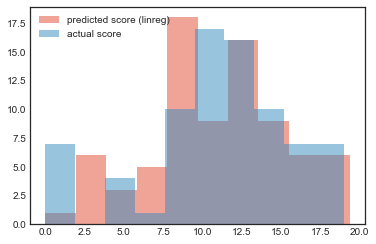

Root mean squared error =  1.9274247368113382


In [9]:
# first model: linear regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(xtrain,ytrain)

# generate predictions and concatenate with actual scores
linreg_preds = linreg.predict(xtest)

linreg_preds = pd.DataFrame({'linreg_pred':linreg_preds})
linreg_preds.reset_index(drop=True, inplace=True)

ytest = pd.DataFrame({'score':ytest})
ytest.reset_index(drop=True, inplace=True)

ytest_linreg_preds = pd.concat([linreg_preds,ytest],axis='columns')

# clean predictions: convert <0 to 0, and >20 to 20
ytest_linreg_preds.loc[ytest_linreg_preds['linreg_pred']<0,'linreg_pred'] = 0
ytest_linreg_preds.loc[ytest_linreg_preds['linreg_pred']>20,'linreg_pred'] = 20

# compare predicted and actual market values
print(ytest_linreg_preds.describe())

plt.hist(ytest_linreg_preds['linreg_pred'], alpha=0.5, label='predicted score (linreg)')
plt.hist(ytest_linreg_preds['score'], alpha=0.5, label='actual score')
plt.legend(loc='upper left')
plt.show()

# calculate root mean squared error for the test set
print('Root mean squared error = ', np.sqrt(((ytest_linreg_preds['score'] - ytest_linreg_preds['linreg_pred'])**2).mean()))

       lassoreg_pred      score
count      79.000000  79.000000
mean       10.941992  11.025316
std         4.184821   4.790414
min         0.000000   0.000000
25%         8.440114   9.000000
50%        11.463057  12.000000
75%        13.878350  14.000000
max        18.951199  19.000000


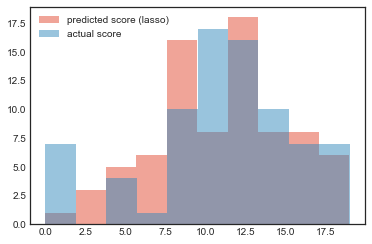

Root mean squared error =  1.8751781767239388
Lasso picked 9 variables and eliminated the other 45 variables


Text(0.5,1,'Coefficients in the Lasso Model')

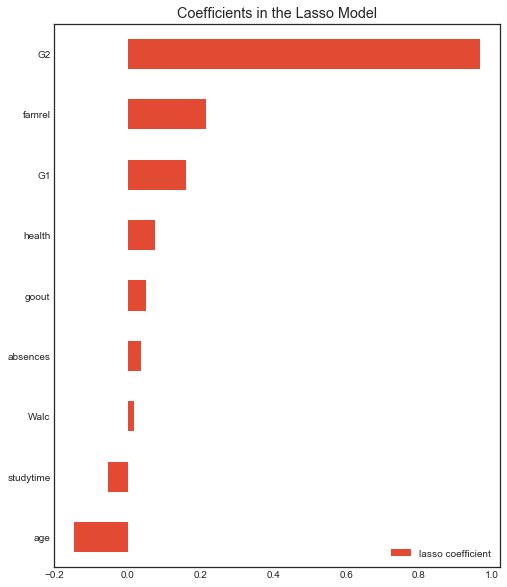

In [10]:
# second model: lasso regression
from sklearn.linear_model import LassoCV
lassoreg = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0005]).fit(xtrain,ytrain)

# generate predictions and concatenate with actual scores
lassoreg_preds = lassoreg.predict(xtest)

lassoreg_preds = pd.DataFrame({'lassoreg_pred':lassoreg_preds})
lassoreg_preds.reset_index(drop=True, inplace=True)

ytest_lassoreg_preds = pd.concat([lassoreg_preds,ytest],axis='columns')

# clean predictions: convert <0 to 0, and >20 to 20
ytest_lassoreg_preds.loc[ytest_lassoreg_preds['lassoreg_pred']<0,'lassoreg_pred'] = 0
ytest_lassoreg_preds.loc[ytest_lassoreg_preds['lassoreg_pred']>20,'lassoreg_pred'] = 20

# compare predicted and actual market values
print(ytest_lassoreg_preds.describe())

plt.hist(ytest_lassoreg_preds['lassoreg_pred'], alpha=0.5, label='predicted score (lasso)')
plt.hist(ytest_lassoreg_preds['score'], alpha=0.5, label='actual score')
plt.legend(loc='upper left')
plt.show()

# calculate root mean squared error for the test set
print('Root mean squared error = ', np.sqrt(((ytest_lassoreg_preds['score'] - ytest_lassoreg_preds['lassoreg_pred'])**2).mean()))

# check how many variables were dropped by lasso regression
coef = pd.Series(lassoreg.coef_, index = xtrain.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

# view the coefficients on the variables that weren't dropped by lasso regression
nonzero_coef = pd.DataFrame({'lasso coefficient': coef[coef!=0].sort_values()})
mpl.rcParams['figure.figsize'] = (8.0, 10.0)
nonzero_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

the optimized hyperparameters are:  {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
after optimization, the mean training MSE is: 0.8033
after optimization, the mean validation MSE is: 5.7444
Root mean squared error =  2.138987329342314


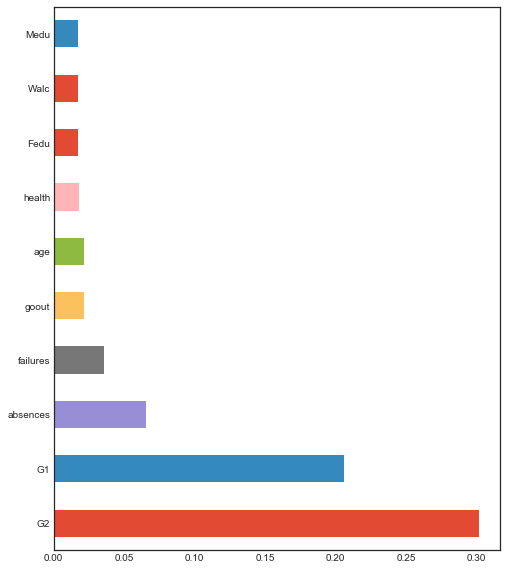

In [11]:
# third model: random forest
from sklearn.ensemble import RandomForestRegressor

# use random search to optimize the hyperparameters, while building the optimal model concurrently
from scipy.stats import randint
from scipy.stats import uniform

param_dist = {'max_depth': randint(5,30),
              'n_estimators': [300],
              'max_features': ['sqrt']
             }

tune_model = model_selection.RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                                                param_distributions=param_dist,
                                                scoring = "neg_mean_squared_error",
                                                cv = 5,
                                                n_iter = 10) # number of iterations of random search

tune_model.fit(xtrain, ytrain)

#print(tune_model.cv_results_['params'])
print('the optimized hyperparameters are: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("after optimization, the mean training MSE is: {:.4f}". format(-tune_model.cv_results_['mean_train_score'][tune_model.best_index_])) 
#print(tune_model.cv_results_['mean_test_score'])
print("after optimization, the mean validation MSE is: {:.4f}". format(-tune_model.cv_results_['mean_test_score'][tune_model.best_index_]))

# use optimized hyperparameters to build random forest
my_rf = RandomForestRegressor(n_jobs = -1, # fully utilize the cores on your computer
                              n_estimators = tune_model.best_params_['n_estimators'], # number of trees
                              max_features = tune_model.best_params_['max_features'], # number of features to consider at each split
                              max_depth = tune_model.best_params_['max_depth']) # maximum tree depth

# fit the random forest
rf_model1 = my_rf.fit(xtrain,ytrain)

# view feature importances
feature_importances = pd.Series(rf_model1.feature_importances_, index=xtrain.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance; for pandas dataframe sorting, refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
feature_importances.nlargest(10).plot(kind='barh')

# generate predictions and concatenate with actual scores
rf_preds = rf_model1.predict(xtest)

rf_preds = pd.DataFrame({'rf_pred':rf_preds})
rf_preds.reset_index(drop=True, inplace=True)

ytest_rf_preds = pd.concat([rf_preds,ytest],axis='columns')

# clean predictions: convert <0 to 0, and >20 to 20
ytest_rf_preds.loc[ytest_rf_preds['rf_pred']<0,'rf_pred'] = 0
ytest_rf_preds.loc[ytest_rf_preds['rf_pred']>20,'rf_pred'] = 20

# calculate root mean squared error for the test set
print('Root mean squared error = ', np.sqrt(((ytest_rf_preds['score'] - ytest_rf_preds['rf_pred'])**2).mean()))